# ANALYSIS OF REAL DATA (SRON)

From real MnKa1, MnKa2, MnKb it creates a library of optimal filters and reconstruct (and calibrate) data calculating FWHM of lines

**Energy units are eV**

0. Imports and definitions

1. Creation of Kas library

        1.1. Transform h5 files to FITS (using PHASE info) 
        1.2. Populate PH_ID column with row (record) number
        1.3. Select records with Ka1 and Ka2 lines (by limiting the Pulse height)
        1.4. Create a library with this new file with Kas lines

2. Creation of Ka2 library

    2.1 Reconstruct Kas data with initial library
    
    2.2 Select only Ka2 pulses not in multiple-pulse records (from R script)
    
        2.2.0 Find/identify multiple-pulse records
        2.2.1 Read data from HR Kas evt file to identify Ka1 and Ka2
        2.2.2 Fit a double Gaussian to select Ka2 pulses
        2.2.3 Select PH_ID of (non)Ka2 pulses
        2.2.4 Extract Ka2 pulses to build the new library
        
    2.3 Build the new library of Ka2 pulses
 
3. Reconstruct all pulses with new Ka2 library

4. Calibrate data fitting 2 Gaussians (Kas) + 1 Gaussian (Kb)

        4.1 Read HR pulses
        4.2 Fit 2 gaussians to Kas and 1 gaussian to Kb
        4.3 Create gain scale
        4.4 Calibrate energies
        
        
5. Get FWHM of Kas lines fitting Voigt profiles

6. Jitter correction

    6.1 Plot recon PH vs PHASE (PHI+LAGS) & Fit a polynomial
    
    6.2 Fit gaussians, create new Gain scale and re-calibrate energies
    
    6.3 Fit histogram of jitter-corrected energies
    
7. baseline drift correction

    7.1 Plot jiterr_recon PH vs Baseline & Fit polynomial
    
    7.2 Fit gaussians, create new Gain scale and re-calibrate energies
    
    7.3 Fit histogram of baseline-jitter-corrected energies
        

## 0) Imports and definitions

In [1]:
from subprocess import check_call, check_output,STDOUT
from astropy.io import fits
from scipy.stats import norm
from scipy.optimize import curve_fit
from statistics import mean
import math
import sys, os
import shutil, tempfile, shlex
import numpy as np
import numpy.polynomial.polynomial as poly
import auxpy
import matplotlib.pyplot as plt
from datetime import datetime
import pandas
import pprint
from astropy.modeling import models, fitting

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"

In [2]:
# data files
fileNum = "2"
noiseNum = "1"
resDir = "file" + str(fileNum) + "noise" + str(noiseNum)
if not os.path.exists(resDir):
    os.makedirs(resDir)
ratio = 5 # ratio Ka2_gaussProb/Ka1_gaussProb
file0ph = "file" + fileNum + "ph.fits"   # initial file with all records
fileph  = "file" + fileNum + "ph_phid.fits" # initial file with all records and PH_ID column populated
fileph_Kas = "file" + fileNum + "ph_phid_Kas.fits" # data file with only those records with Kas lines
noisefile = "noise" + noiseNum + "ph_8192_noisespec.fits"

In [3]:
PHmin = 159000 # ADC units to limit Kas lines
PHmax = 161000 
# Calibration lines CALDB20161122: relative amplitudes of Lorentzians in table = amplitudes of fitted Voigt 
# MnKa
ilabels = ["Ka11","Ka12", "Ka13", "Ka14", "Ka15", "Ka16",  "Ka21", "Ka22"]
energies_eV = np.array([5898.882, 5897.898, 5894.864, 5896.566, 5899.444, 5902.712, 5887.772, 5886.528], dtype=np.float64)
fwhms_eV = np.array([1.7145, 2.0442, 4.4985, 2.6616, 0.97669, 1.5528, 2.3604, 4.2168], dtype=np.float64)
rel_amplitudes = np.array([0.784, 0.263, 0.067, 0.095, 0.071, 0.011, 0.369, 0.1], dtype=np.float64)
MnKas = auxpy.RxLines(complabel="MnKa", ilabels=ilabels, energies_eV=energies_eV, fwhms_eV=fwhms_eV, rel_amplitudes=rel_amplitudes)
MnKas_cmass = 5894.40 # eV
Ka2_cmass = 5887.77 # eV 
Ka1_cmass = 5897.97 # eV 

ilabels = ['Kb1', 'Kb2', 'Kb3', 'Kb4', 'Kb5']
energies_eV = np.array([6490.89, 6486.31, 6477.73, 6490.06, 6488.83], dtype=np.float64)
fwhms_eV = np.array([1.83, 9.4, 13.22, 1.81, 2.81,], dtype=np.float64)
rel_amplitudes = np.array([0.608, 0.109, 0.077, 0.397, 0.176], dtype=np.float64)
MnKb = auxpy.RxLines(complabel="MnKb", ilabels=ilabels, energies_eV=energies_eV, fwhms_eV=fwhms_eV, rel_amplitudes=rel_amplitudes)
MnKb_cmass = 6486.38 # eV

In [4]:
# library Kas creation
plen = 8192
oflen = 8192
preBuffer = 0
method = "OPTFILT"
F0orB0 = "F0"
nS = 5
sU = 3
sD = 4
KaseV = 5895 # eV reference energy: 8.2%*5.88765(Ka1)+16.2%*5.89875(Ka2)
libKas = resDir + "/" + "library_Kas_" + str(plen) + ".fits"

In [5]:
# reconstructed files
evtKas_libKas = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKas_" + method + str(oflen) + ".fits"
evtKas_libKas_HR = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKas_" + method + str(oflen) + "_HR.fits"
evtKas_libKa2 = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evtKas_libKa2_HR = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"
evt_libKa2 = resDir + "/" + "evt_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evt_libKa2_HR = resDir + "/" + "evt_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"
evt_libKa2_abs = resDir + "/" + "evtabs_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evt_libKa2_abs_HR = resDir + "/" + "evtabs_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"

In [6]:
# library Ka2 creation
fileph_Ka2 = resDir + "/" + "file_Ka2.fits" # data file with only those single records with Ka2 lines
libKa2 = resDir + "/" + "library_Ka2_ratio" + str(ratio) + "_" + str(plen) + ".fits"

## 1) Creation of Kas library
### 1.1 Transform h5 files to FITS (using PHASE)

### 1.2 Populate PH_ID column with row (record) number
The idea is to be able to later identify which records contains pulses with the appropriate energy to build the library

In [ ]:
run = False
if run:
    comm =  ("fcalc infile=" + file0ph + "+8 outfile=" + fileph + " clname=PH_ID expr='#ROW'")
    try:
        print("Populating PH_ID column")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error populating PH_ID column with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 1.3 Select records with Ka1 and Ka2 lines (by limiting the Pulse height)

In [ ]:
run = False
if run:
    comm = ("fselect  infile=" + fileph + "+8 outfile=" + fileph_Kas + " expr='max(ADC)>" + str(PHmin) + " && max(ADC)<" + str(PHmax) +"'")
    try:
        print("Selecting Kas by Pulse Height")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting Kas by Pulse Height with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 1.4 Create a library with this new file with Kas lines

In [ ]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + tmpFile + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKas + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=0 OFLib=yes FilterDomain=F " + 
            " detectionMode=STC detectSP=1 FilterMethod=" + F0orB0 + " clobber=yes EventListSize=1000" + 
            " EnergyMethod=" + method + " LagsOrNot=1 tstartPulse1=0 tstartPulse2=0 OFNoise=NSD " + 
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(KaseV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " NoiseFile=" + noisefile +
            " monoenergy=" + str(KaseV) + " preBuffer=" + str(preBuffer))
    try:
        print("Building initial library (Kas)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Building initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    os.remove(tmpFile)

## 2. Creation of Ka2 library

### 2.1 Reconstruct real data with initial library

In [ ]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + evtKas_libKas + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKas + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(KaseV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ initial library (Kas)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evtKas_libKas + " outfile=" + evtKas_libKas_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR Kas evts")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 2.2 Select only Ka2 pulses not in multiple-pulse records 

#### 2.2.0 Find/identify multiple-pulse records

In [ ]:
# dump records info
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evtKas_libKas + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
    
# find single records
dataKas = pandas.read_csv("pulse.txt", skiprows=0, sep="\s+")
n_ocurr = dataKas.PH_ID.value_counts() # number of ocurrences of each PH_ID
dataKas_single_PH_ID = list()
for key in sorted(n_ocurr.keys()):
    if n_ocurr[key] == 1:
        #print("Single record for PH_ID=", key)
        dataKas_single_PH_ID.append(key)

os.remove("pulse.txt")
#print("Single records in ",fileph_Kas, "=", dataKas_single_PH_ID)
print("Number of Kas records in",fileph_Kas, "=", len(dataKas))
print("Number of Single Kas records in",fileph_Kas, "=", len(dataKas_single_PH_ID))

#### 2.2.1 Read data from HR Kas evt file to identify Ka1 and Ka2

In [ ]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evtKas_libKas_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
dataKas_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of HR Kas pulses in",fileph_Kas, "=", len(dataKas_HR))


#### 2.2.2 Fit a double Gaussian to select Kas pulses

In [ ]:
nbinsKas = 100

# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple-pulse rows)
# print(min(dataKas_HR.SIGNAL), max(dataKas_HR.SIGNAL))
dataKas_HR = dataKas_HR[(dataKas_HR.SIGNAL>5.87) & (dataKas_HR.SIGNAL<5.93)]
# print(min(dataKas_HR.SIGNAL), max(dataKas_HR.SIGNAL))
(PHmin,PHmax) = auxpy.fit2GaussAndRatio(data=dataKas_HR.SIGNAL, a1=60, a2=140, mean1=5.892, mean2=5.90, 
                                        sig1=0.005, sig2=0.005, nbins1=nbinsKas, ratio=ratio, xlab="Reconstructed PH (a.u.)",
                                        xlim=(5.87,5.93), ylim=(0,150))
print("PHmin=",PHmin, "PHmax=", PHmax)

#### 2.2.3 Select PH_ID of (non)Ka2 pulses

In [ ]:

#select PH_IDs for Ka2 (in [PHmin,PHmax] interval)
dataKa2 = dataKas_HR[(dataKas_HR.SIGNAL >= PHmin) & (dataKas.SIGNAL <= PHmax)]
print("Kas pulses which are Ka2 pulses in PHmin,PHmax interval=", len(dataKa2))

PH_ID_Ka2 = dataKa2.PH_ID.to_list()
PH_ID_Ka2_single = set(PH_ID_Ka2).intersection(dataKas_single_PH_ID) # good Ka2 pulses

#select PH_IDs to exclude Ka2 in single-pulse records
PH_ID_noKa2 = list(set(dataKas.PH_ID.to_list()).difference(PH_ID_Ka2_single))
print("Kas pulses which are not non-Ka2-single pulses:", len(PH_ID_noKa2))

#### 2.2.4 Extract Ka2 pulses to build a new library

In [ ]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    nphs = len(PH_ID_noKa2)
    # first iteration
    expr = "'PH_ID != " + str(PH_ID_noKa2[0]) + "'"
    comm = ("fselect infile=" + fileph_Kas + "+8 outfile=" + fileph_Ka2 + " clobber=yes expr=" + expr)
    try:
        print("Selecting Ka2 pulses")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting Ka2 pulses with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    # other non-selections follow
    iph = 1
    while iph < nphs:
        expr = "'"
        iiph = 1
        while (iiph < 20 and iph < nphs-1):
            expr = expr + "PH_ID != " + str(PH_ID_noKa2[iph]) + " && "
            iiph += 1
            iph  += 1

        expr = expr + "PH_ID != " + str(PH_ID_noKa2[iph]) + "'"
        iph += 1
        comm = ("fselect infile=" + fileph_Ka2 + "+8 outfile=" + tmpFile + " clobber=yes expr=" + expr)
        try:
            print("Selecting Ka2 pulses")
            print("iph=" + str(iph) + "/" + str(nphs))
            print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error Selecting Ka2 pulses with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise
        shutil.copy(tmpFile, fileph_Ka2)
        os.remove(tmpFile)
        
    print("Finshed selection of Ka2 events")
    # raise SystemExit("Stop after selection of Ka2")

### 2.3 Build the new library of Ka2 pulses

In [ ]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    comm = ("tesreconstruction Recordfile=" + fileph_Ka2 + " TesEventFile=" + tmpFile + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=0 OFLib=yes FilterDomain=F " + 
            " detectionMode=STC detectSP=1 FilterMethod=" + F0orB0 + " clobber=yes EventListSize=1000" + 
            " EnergyMethod=" + method + " LagsOrNot=1 tstartPulse1=0 tstartPulse2=0 OFNoise=NSD " + 
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " NoiseFile=" + noisefile +
            " monoenergy=" + str(Ka2eV) + " preBuffer=" + str(preBuffer))
    try:
        print("Building new library (Ka2)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Building initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    os.remove(tmpFile)

## 3. Reconstruct all pulses with new Ka2 library

In [ ]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph + " TesEventFile=" + evt_libKa2 + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ library (Ka2)")
        print(comm)
        args = shlex.split(comm)
        #check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Ka2) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evt_libKa2 + " outfile=" + evt_libKa2_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR evts")
        print(comm)
        args = shlex.split(comm)
        #check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas & Kb evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

## 4. Calibrate data fitting 2 Gaussians

### 4.1 Read HR pulses

In [7]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN'" 
comm = ("fdump wrap=yes infile=" + evt_libKa2_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes pagewidth=256")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
data_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of initial (all energies) HR pulses:", len(data_HR)) 
#print(data_HR)


FDUMPing evt file
Number of initial (all energies) HR pulses: 13758


### 4.2 Fit 2 gaussians to Kas and 1 gaussian to Kb

Missing 1 records due to unusual baseline(< 100000.0 )
Missing 1 records due to unusual baseline(< 100000.0 )
Min BSLN in dataKb_HR: 100701
Message (Kas)= The relative error between two consecutive iterates is at most 0.000000
Message (Kb)= The relative error between two consecutive iterates is at most 0.000000


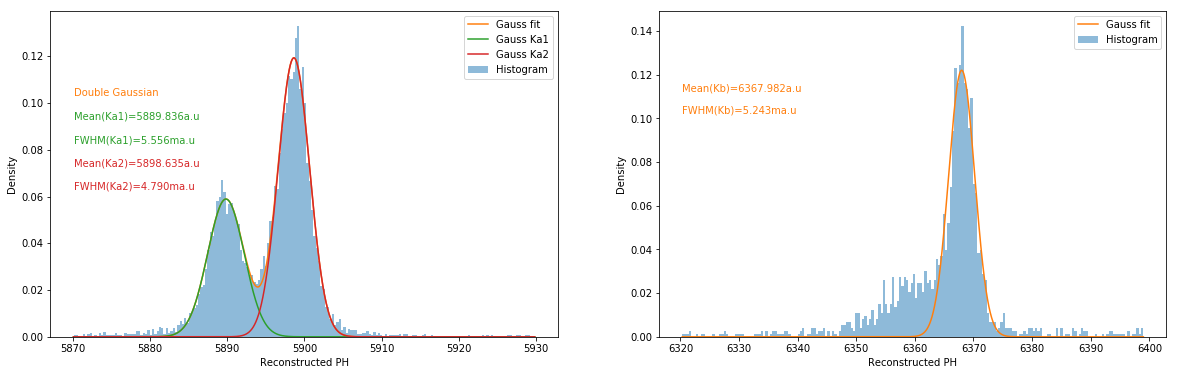

In [8]:
nbinsKas = 200
nbinsKb = 200
minBSLN = 1e5

# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple rows)
dataKas_HR = data_HR[(data_HR.SIGNAL>5.87) & (data_HR.SIGNAL<5.93)]
len1 = len(dataKas_HR)
dataKas_HR = dataKas_HR[dataKas_HR.BSLN>minBSLN]
len2 = len(dataKas_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")

# select data in Kb range
dataKb_HR = data_HR[(data_HR.SIGNAL>6.32) & (data_HR.SIGNAL<6.40)]
len1 = len(dataKb_HR)
dataKb_HR = dataKb_HR[dataKb_HR.BSLN>minBSLN]
len2 = len(dataKb_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")
print("Min BSLN in dataKb_HR:", min(dataKb_HR.BSLN))

# Fit Gaussians and plot results
(mean1, mean2, mean3) = auxpy.fit3gauss2hist(data1=1e3*dataKas_HR.SIGNAL, data2=1e3*dataKb_HR.SIGNAL,
                                       a1=0.056, a2=0.090, a3=0.090, mean1=5889, mean2=5900, mean3=6350,
                                       sig1=5, sig2=5, sig3=5, nbins1=nbinsKas, nbins2=nbinsKb,
                                       xlab="Reconstructed PH")

### 4.3 Create gain scale

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope             intercept     
    ------------------ -------------------
    1.2527769746762107 -1491.2890209102632
Residuals= [0.33874778]
Params= [ 1.25277697e+00 -1.49128902e+03]
RMSE: 0.33602965211169006
R-squared: 0.9999985578333632


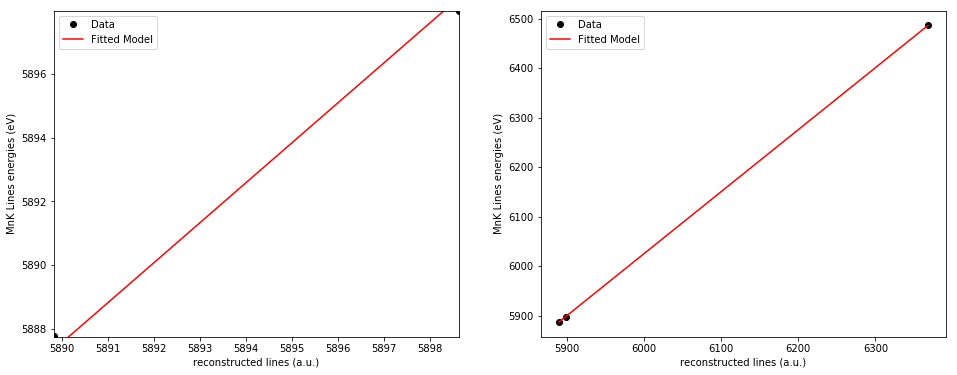

In [9]:
lines = (Ka2_cmass, Ka1_cmass, MnKb_cmass)
recon_lines = (mean1,mean2,mean3)
(slope, inter) = auxpy.gainScaleLinearFit(xData=recon_lines, yData=lines, ylab="MnK Lines energies (eV)")

### 4.4 Calibrate energies (eV)

Text(0,0.5,'Density')

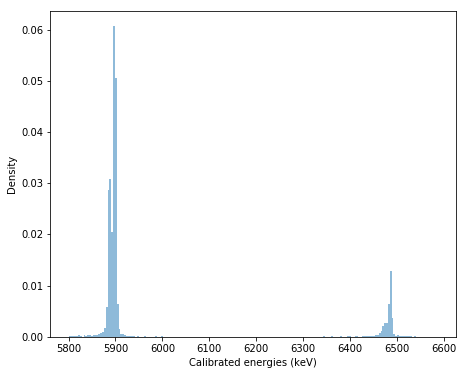

In [10]:
eners_HR = inter + slope * 1e3*data_HR.SIGNAL
# select data in Kas/Kb range (otherwise there is always a smaller pulse comimg from multiple rows)
enerKs_HR = eners_HR[(eners_HR > 5800) & (eners_HR < 6600)]

# create histogram
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1, 2, 1)
bin_heights, bin_borders, _ = ax1.hist(enerKs_HR,bins=200, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
ax1.set_xlabel("Calibrated energies (keV)")
ax1.set_ylabel("Density")


## 5. Get FWHM of Kas lines fitting Voigt profiles

Message ( MnKa )= The relative error between two consecutive iterates is at most 0.000000
Line consistency check status: 0 (0 = OK)
Message ( MnKb )= The relative error between two consecutive iterates is at most 0.000000
Line consistency check status: 0 (0 = OK)


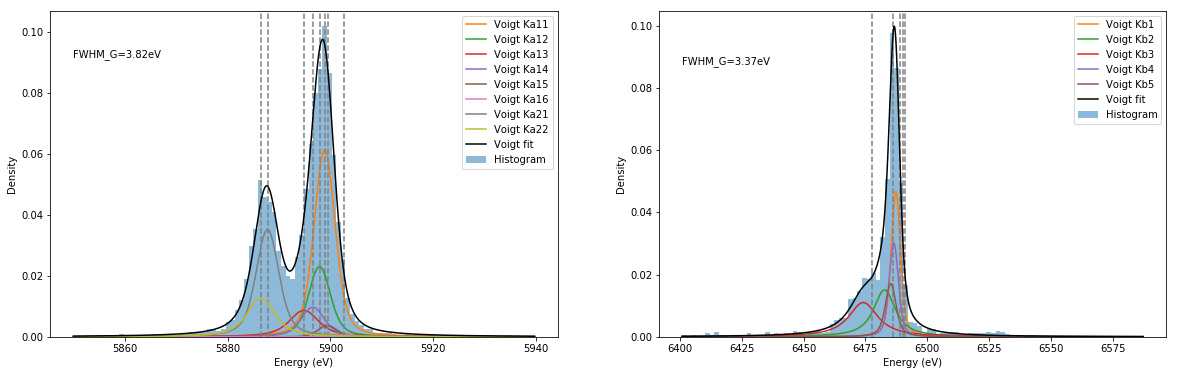

In [11]:
nbinsKas = 100
nbinsKb = 100
# select data in Kas/Kb range (otherwise there is always a smaller pulse comimg from multiple rows)
enerKas_HR = eners_HR[(eners_HR > 5850) & (eners_HR < 5940)]
#enerKas_HR.to_csv(resDir + "/enerKas_HR.hist", header=None, index=False )
enerKb_HR = eners_HR[(eners_HR>6400) & (eners_HR<6600)]

auxpy.fitVoigt2hist(data1=enerKas_HR, data2=enerKb_HR, lines1=MnKas, lines2=MnKb, nbins1=nbinsKas, nbins2=nbinsKb)

## 6. Jitter correction

### 6.1 Plot Pulse Height vs PHASE (distance between trigger and parabola fit = PHI + LAGS) & fit polynomial

Fit Kas= 5.896+ (-0.003)*x+(0.003)*x²
Fit Kas (corrected)= 5.896+ (0.000)*x+(-0.000)*x²
Fit Kas= 6.365+ (-0.003)*x+(0.003)*x²
Fit Kas (corrected)= 6.365+ (-0.000)*x+(0.000)*x²


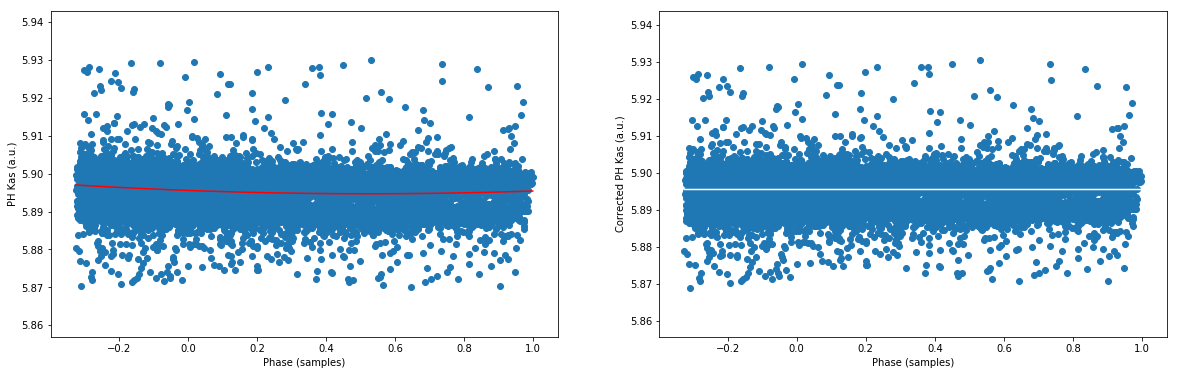

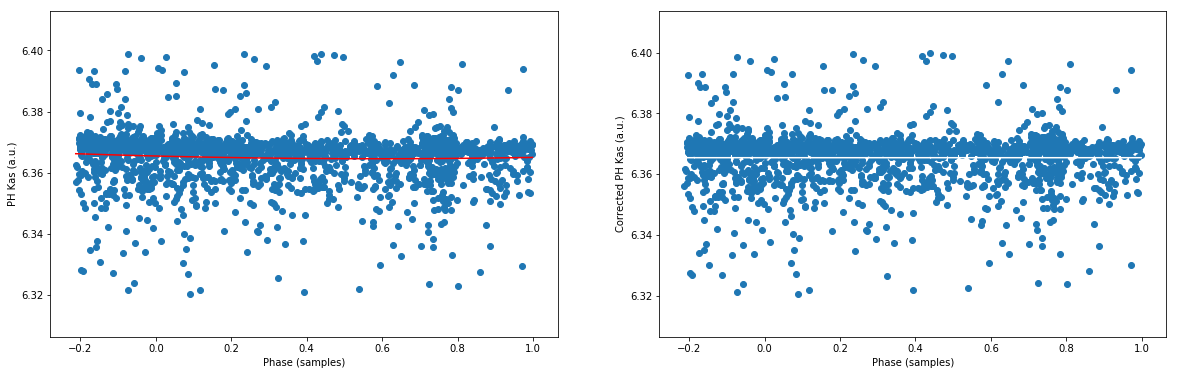

In [12]:
# FROM ABOVE:
#dataKas_HR = data_HR[(data_HR.SIGNAL>5.80) & (data_HR.SIGNAL<5.95) & (data_HR.BSLN>50000)]
#dataKb_HR = data_HR[(data_HR.SIGNAL>6.15) & (data_HR.SIGNAL<6.35) & (data_HR.BSLN>50000)]

phaseKas_HR = dataKas_HR.PHI + dataKas_HR.LAGS
phaseKb_HR = dataKb_HR.PHI + dataKb_HR.LAGS
#print(len(phaseKas_HR))

dataKas_HR_jitter = auxpy.jitterCorr(reconPH=dataKas_HR.SIGNAL, phase=phaseKas_HR)
dataKb_HR_jitter = auxpy.jitterCorr(reconPH=dataKb_HR.SIGNAL, phase=phaseKb_HR)


### 6.2 Fit gaussians, create new Gain scale and re-calibrate energies

Message (Kas)= The relative error between two consecutive iterates is at most 0.000000
Message (Kb)= The relative error between two consecutive iterates is at most 0.000000


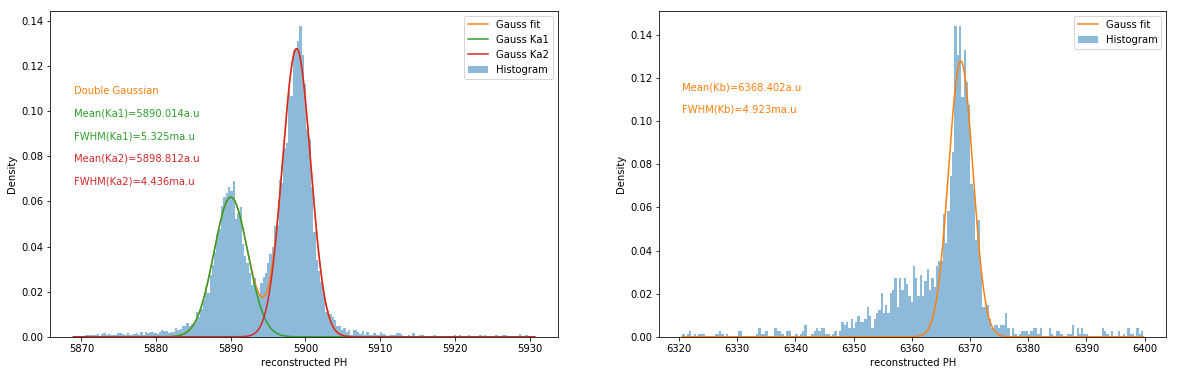

In [13]:
nbinsKas = 200
nbinsKb = 200

(mean1j, mean2j, mean3j) = auxpy.fit3gauss2hist(data1=1e3*dataKas_HR_jitter, data2=1e3*dataKb_HR_jitter, 
                                          a1=0.056, a2=0.11, a3=0.1, mean1=5889, mean2=5900, mean3=6370,
                                          sig1=5, sig2=5, sig3=5, nbins1=nbinsKas, nbins2=nbinsKb, 
                                          xlab="reconstructed PH", plot=True)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope             intercept     
    ------------------ -------------------
    1.2521361968415226 -1487.7338433371326
Residuals= [0.33304738]
Params= [ 1.25213620e+00 -1.48773384e+03]
RMSE: 0.33319032717495606
R-squared: 0.9999985821019359


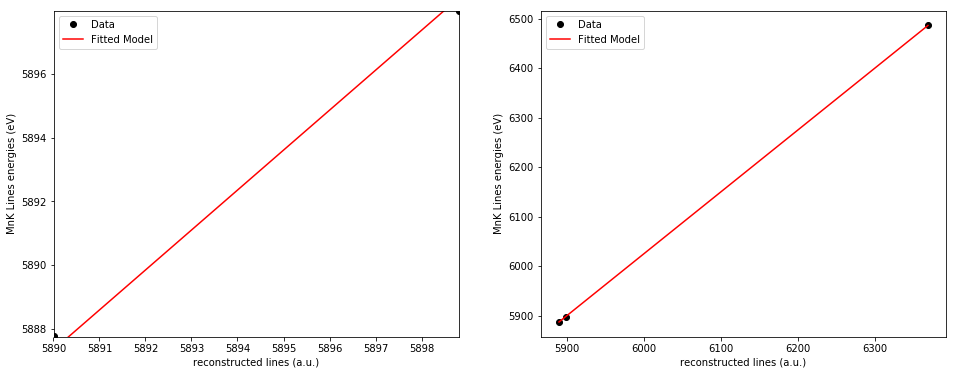

In [14]:
# create gain scale
recon_lines = (mean1j,mean2j,mean3j)
(slope, inter) = auxpy.gainScaleLinearFit(xData=recon_lines, yData=lines, ylab="MnK Lines energies (eV)")

In [15]:
# recalibrate energies
enerKas_HR_jitter = inter + slope * 1e3*dataKas_HR_jitter
enerKas_HR_jitter = enerKas_HR_jitter[(enerKas_HR_jitter > 5860) & (enerKas_HR_jitter < 5940)]

enerKb_HR_jitter = inter + slope * 1e3*dataKb_HR_jitter
enerKb_HR_jitter = enerKb_HR_jitter[(enerKb_HR_jitter>6400) & (enerKb_HR_jitter<6600)]

print(min(enerKas_HR_jitter), max(enerKas_HR_jitter))

5860.988821184842 5938.287167100262


### 6.3 Fit histogram of jitter-corrected energies

Message ( MnKa )= The relative error between two consecutive iterates is at most 0.000000
Line consistency check status: 0 (0 = OK)
Message ( MnKb )= The relative error between two consecutive iterates is at most 0.000000
Line consistency check status: 0 (0 = OK)


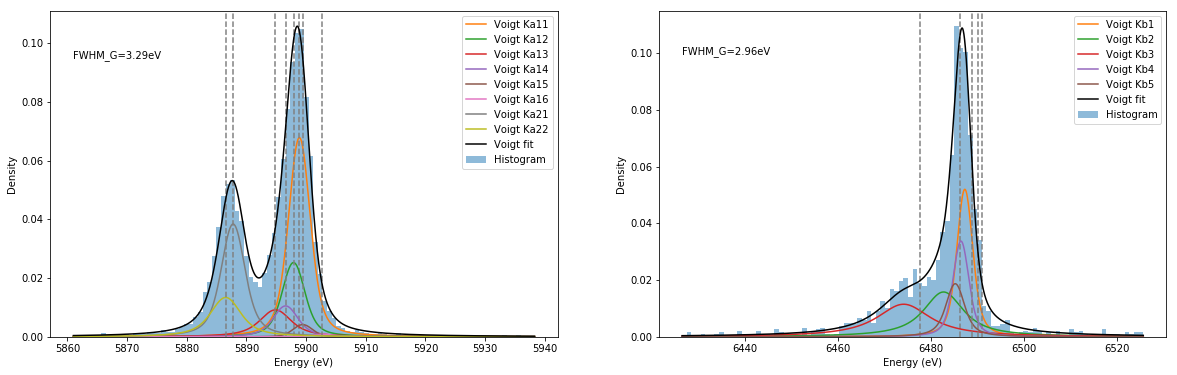

In [16]:
nbinsKas = 100
nbinsKb = 100

auxpy.fitVoigt2hist(data1=enerKas_HR_jitter, data2=enerKb_HR_jitter, lines1=MnKas, lines2=MnKb, nbins1=nbinsKas, nbins2=nbinsKb)


## 7. baseline drift correction

### 7.1 Plot jiterr_recon PH vs Baseline & Fit polynomial


100701
Fit Kas= 5.879+ (0.000)*x+(-0.000)*x²
Fit Kas (corrected)= 5.879+ (0.000)*x+(-0.000)*x²
Fit Kb= 6.389+ (-0.000)*x+(0.000)*x²
Fit Kb (corrected)= 6.389+ (-0.000)*x+(0.000)*x²


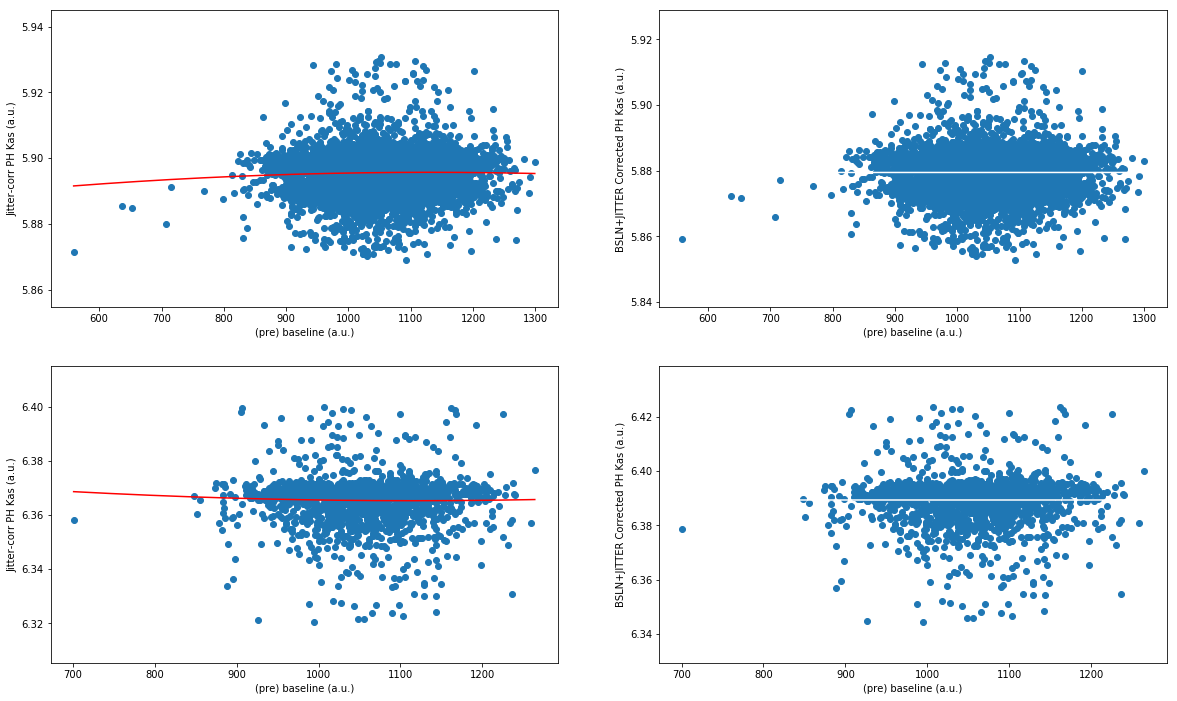

In [17]:
baseKas_HR = dataKas_HR.BSLN - 1e5
baseKb_HR = dataKb_HR.BSLN - 1e5
print(min(dataKb_HR.BSLN))

######## Kas ####################
# plot baselines
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(baseKas_HR, dataKas_HR_jitter, marker="o")
# fit polynomial
x_interval_for_fit = np.linspace(min(baseKas_HR), max(baseKas_HR), 10000)
coefs = poly.polyfit(x=baseKas_HR, y=dataKas_HR_jitter, deg=2) 
#print(coefs)
ffit = poly.polyval(x_interval_for_fit, coefs)
ax1.plot(x_interval_for_fit, ffit,'-', color="red")
ax1.set_xlabel("(pre) baseline (a.u.)")
ax1.set_ylabel("Jitter-corr PH Kas (a.u.)")
print("Fit Kas=",'{:0.3f}'.format(coefs[0]) + "+ (" + '{:0.3f}'.format(coefs[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefs[2]) + ")*x²" )
# subtract polynomial (flat baseline effect)
ax2 = fig.add_subplot(2, 2, 2)
dataKas_HR_jitter_bsln = dataKas_HR_jitter - coefs[1]*baseKas_HR - coefs[2]*baseKas_HR**2
ax2.scatter(baseKas_HR, dataKas_HR_jitter_bsln, marker="o")
ax2.set_xlabel("(pre) baseline (a.u.)")
ax2.set_ylabel("BSLN+JITTER Corrected PH Kas (a.u.)")
coefsB = poly.polyfit(x=baseKas_HR, y=dataKas_HR_jitter_bsln, deg=2)
print("Fit Kas (corrected)=",'{:0.3f}'.format(coefsB[0]) + "+ (" + '{:0.3f}'.format(coefsB[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefsB[2]) + ")*x²" )
ffitB = poly.polyval(x_interval_for_fit, coefsB)
ax2.plot(x_interval_for_fit, ffitB,'-', color="white")

######## Kb ####################
# plot baselines
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(baseKb_HR, dataKb_HR_jitter, marker="o")
# fit polynomial
x_interval_for_fit = np.linspace(min(baseKb_HR), max(baseKb_HR), 10000)
coefs = poly.polyfit(x=baseKb_HR, y=dataKb_HR_jitter, deg=2) # recommended instead of np.polyfit + np.poly1d
ffit = poly.polyval(x_interval_for_fit, coefs)
ax3.plot(x_interval_for_fit, ffit,'-', color="red")
ax3.set_xlabel("(pre) baseline (a.u.)")
ax3.set_ylabel("Jitter-corr PH Kas (a.u.)")
print("Fit Kb=",'{:0.3f}'.format(coefs[0]) + "+ (" + '{:0.3f}'.format(coefs[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefs[2]) + ")*x²" )
# subtract polynomial (flat jitter effect)
ax4 = fig.add_subplot(2, 2, 4)
dataKb_HR_jitter_bsln = dataKb_HR_jitter - coefs[1]*baseKb_HR - coefs[2]*baseKb_HR**2
ax4.scatter(baseKb_HR, dataKb_HR_jitter_bsln, marker="o")
ax4.set_xlabel("(pre) baseline (a.u.)")
ax4.set_ylabel("BSLN+JITTER Corrected PH Kas (a.u.)")
coefsB = poly.polyfit(x=baseKb_HR, y=dataKb_HR_jitter_bsln, deg=2)
print("Fit Kb (corrected)=",'{:0.3f}'.format(coefsB[0]) + "+ (" + '{:0.3f}'.format(coefsB[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefsB[2]) + ")*x²" )
ffitB = poly.polyval(x_interval_for_fit, coefsB)
ax4.plot(x_interval_for_fit, ffitB,'-', color="white")

### 7.2 Fit gaussians, create new Gain scale and re-calibrate energies

Message (Kas)= The relative error between two consecutive iterates is at most 0.000000
Message (Kb)= The relative error between two consecutive iterates is at most 0.000000


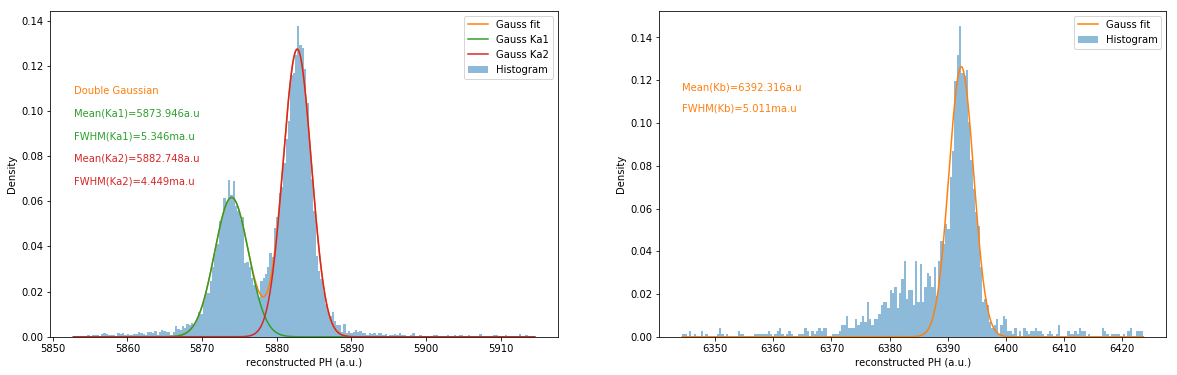

In [18]:
nbinsKas = 200
nbinsKb = 200

(mean1bsln, mean2bsln, mean3bsln) = auxpy.fit3gauss2hist(data1=1e3*dataKas_HR_jitter_bsln, data2=1e3*dataKb_HR_jitter_bsln, 
                                                   a1=0.06, a2=0.12, a3=0.11, mean1=5875, mean2=5885, mean3=6395,
                                                   sig1=5, sig2=5, sig3=5, nbins1=nbinsKas, nbins2=nbinsKb,
                                                   xlab="reconstructed PH (a.u.)", plot=True)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept    
    ------------------ -----------------
    1.1547588127427826 -895.203067712517
Residuals= [0.00066564]
Params= [   1.15475881 -895.20306771]
RMSE: 0.014895612676069543
R-squared: 0.9999999971661492


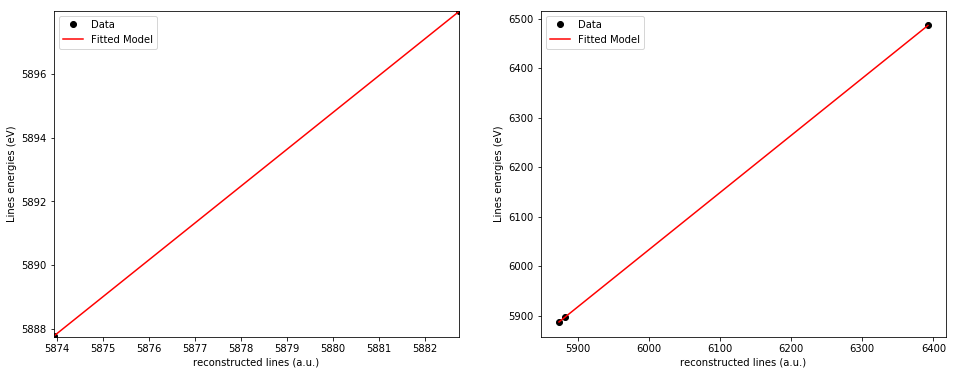

In [19]:
# create gain scale
recon_lines = (mean1bsln,mean2bsln,mean3bsln)
(slope, inter) = auxpy.gainScaleLinearFit(xData=recon_lines, yData=lines)


In [20]:
# recalibrate energies
#enerKas_HR_jitter_bsln = coefs[0] + coefs[1] * dataKas_HR_jitter_bsln + coefs[2] * dataKas_HR_jitter_bsln**2
#enerKb_HR_jitter_bsln = coefs[0] + coefs[1] * dataKb_HR_jitter_bsln + coefs[2] * dataKb_HR_jitter_bsln**2
enerKas_HR_jitter_bsln = inter + slope * 1e3*dataKas_HR_jitter_bsln # eV
enerKas_HR_jitter_bsln = enerKas_HR_jitter_bsln[(enerKas_HR_jitter_bsln > 5860) & (enerKas_HR_jitter_bsln < 5940)]
enerKb_HR_jitter_bsln = inter + slope * 1e3*dataKb_HR_jitter_bsln # eV
enerKb_HR_jitter_bsln = enerKb_HR_jitter_bsln[(enerKb_HR_jitter_bsln>6400) & (enerKb_HR_jitter_bsln<6550)]


### 7.3 Fit histogram of baseline-jitter-corrected energies

Message ( MnKa )= The relative error between two consecutive iterates is at most 0.000000
Line consistency check status: 0 (0 = OK)
Message ( MnKb )= The relative error between two consecutive iterates is at most 0.000000
Line consistency check status: 0 (0 = OK)


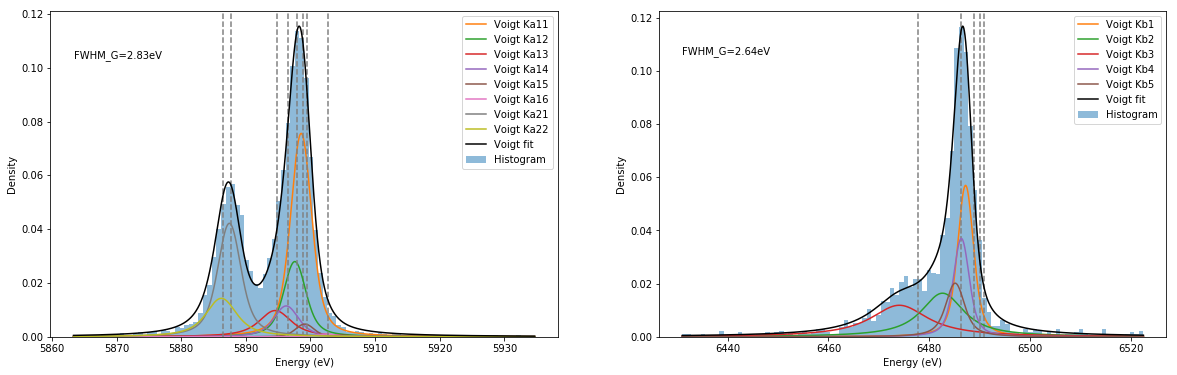

In [21]:
nbinsKas = 100
nbinsKb = 100

auxpy.fitVoigt2hist(data1=enerKas_HR_jitter_bsln, data2=enerKb_HR_jitter_bsln,lines1=MnKas, lines2=MnKb,
               nbins1=nbinsKas, nbins2=nbinsKb, outfig="fit_jitter_bsln.png")


## 8. Absolute value

### 8.1 Reconstruct pulses with Ka2 library and absolute values

In [ ]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph + " TesEventFile=" + evt_libKa2_abs + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ library (Ka2)")
        print(comm)
        args = shlex.split(comm)
        #check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Ka2) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evt_libKa2_abs + " outfile=" + evt_libKa2_abs_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR evts")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas & Kb evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 8.2 Read HR pulses

In [ ]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN'" 
comm = ("fdump wrap=yes infile=" + evt_libKa2_abs_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes pagewidth=256")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
dataAbs_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of initial (all energies) HR pulses:", len(dataAbs_HR)) 
#print(dataAbs_HR)

### 8.3 Fit 2 gaussians to Kas and 1 gaussian to Kb

In [ ]:
nbinsKas = 200
nbinsKb = 200
minBSLN = 1e5
# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple rows)
dataKasAbs_HR = dataAbs_HR[(dataAbs_HR.SIGNAL>5.88) & (dataAbs_HR.SIGNAL<5.93)]
len1 = len(dataKasAbs_HR)
dataKasAbs_HR = dataKasAbs_HR[dataKasAbs_HR.BSLN>minBSLN]
len2 = len(dataKasAbs_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")

# select data in Kb range
dataKbAbs_HR = dataAbs_HR[(dataAbs_HR.SIGNAL>6.30) & (dataAbs_HR.SIGNAL<6.50)]
len1 = len(dataKbAbs_HR)
dataKbAbs_HR = dataKbAbs_HR[dataKbAbs_HR.BSLN>minBSLN]
len2 = len(dataKbAbs_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")
print("Min baseline=",min(dataKbAbs_HR.BSLN))

# Fit Gaussians and plot results
(mean1abs, mean2abs,mean3abs) = auxpy.fit3gauss2hist(data1=1e3*dataKasAbs_HR.SIGNAL, data2=1e3*dataKbAbs_HR.SIGNAL, 
                                               a1=0.056, a2=0.11, a3=0.1, mean1=5890, mean2=5900, mean3=6370, 
                                               sig1=5, sig2=5, sig3=5, nbins1=nbinsKas, nbins2=nbinsKb,
                                               xlab="reconstructed PH (a.u.)", plot=True)


### 8.4 Create gain scale

In [ ]:
recon_lines = (mean1abs,mean2abs,mean3abs)

In [ ]:
# gain scale
(slopeAbs, interAbs) = auxpy.gainScaleLinearFit(xData=recon_lines, yData=lines)

### 8.5 Calibrate energies

In [ ]:
enersAbs_HR = interAbs + slopeAbs * 1e3*dataAbs_HR.SIGNAL
enerKasAbs_HR = enersAbs_HR[(enersAbs_HR > 5860) & (enersAbs_HR < 5940)]
enerKbAbs_HR = enersAbs_HR[(enersAbs_HR>6400) & (enersAbs_HR<6600)]

### 8.6. Get FWHM of Kas lines fitting Voigt profiles

In [ ]:
nbinsKas = 100
nbinsKb = 100

auxpy.fitVoigt2hist(data1=enerKasAbs_HR, data2=enerKbAbs_HR, lines1=MnKas, lines2=MnKb,
              nbins1=nbinsKas, nbins2=nbinsKb)
